# Milestone 1 - EDA and Preprocessing data 

***Important note*** - This is merely a template. you are more than free to change how it looks or create one from scratch.

- Load dataset
- Explore the dataset and ask atleast 5 questions to give you a better understanding of the data provided to you. 
- Visualise the answer to these 5 questions.
- Cleaning the data
    - Tidy up the column names, make sure there is no spaces
    - Observe,comment on and handle inconsistent data.(i.e duplicates, irrelevant data,incorrect data,etc)
    - Observe missing data and comment on why you believe it is missing(MCAR,MAR or MNAR).
    - Handle missing data
    - Observe and comment on outliers
    - Handle outliers
- With every change you are making to the data you need to comment on why you used this technique and how has it affected the data(by both showing the change in the data i.e change in number of rows/columns,change in distrubution, etc and commenting on it).
- Data transformation and feature engineering
    - Add 2 new columns named 'Week number' and 'Date range' and discretize the data into weeks according to the dates. 
        - Tip: Change the datatype of the date feature to datetime type instead of object.
    - Encode any categorical feature(s) and comment on why you used this technique and how the data has changed.
    - If exists , Identify feature(s) which need normalization and show your reasoning. Then choose a technique to normalize the feature(s) and comment on why you chose this technique.
- Additional data extraction
    - Add GPS coordinates for the cities/locations.
    - For this task you can extract the GPS coordinates from an API or web scraping and integrate into your csv file as new features. 
    - Tip 1 - you can find the web scraping and data integration notebooks under 'additional resources'  on the CMS useful.
    - Tip 2 - If you are going to use an API make sure you do not make request for each existing row but rather group by the cities and get their respective coordinates. Making a request for each row is too inefficient and expensive.
    - Tip 3 - Rather than running the code for calling the API each time you load the notebook, the first time you call the API save the results in a csv file and then you could you check if a csv file exists for the GPS coordinates, if so, load directly and don't call APi. Same applies for web scraping.

- Lookup table and load back into new csv file
    - Create a lookup table
    - Load the new dataset into a new csv file named `green_trip_data_{year}-{month}clean.csv`. replace year and month with the appropriate values.
    - Load the lookup table to a csv file called `lookup_table_green_taxis.csv` 
- Bonus: Load the dataset as a parquet file instead of a csv file(Parquet file is a compressed file format).

In [176]:
import pandas as pd
# for visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress
from sklearn.preprocessing import LabelEncoder
import datetime
import geopy
import os
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from geopy.extra.rate_limiter import RateLimiter
import requests

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# 1 - Extraction

In [177]:
def load_data(data_dir: str):
    df = pd.read_csv(data_dir)
    return df
data_dir = "datasets/green_tripdata_2018-11.csv"
trip_df_original = load_data(data_dir)
trip_df = trip_df_original.copy()

In [178]:
trip_df.head()

,Vendor,lpep pickup datetime,lpep dropoff datetime,store and fwd flag,Rate type,PU Location,DO Location,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,payment type,trip type,congestion surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.5,0.5,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.0,0.5,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.5,0.5,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.5,0.5,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.0,0.5,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN


# 2- EDA

- This function return information about the attributes like their names, data type, and the count of the non-null values.

In [179]:
def data_info(df: pd.DataFrame) -> None:
    return df.info()
data_info(trip_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 673297 entries, 0 to 673296
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Vendor                 673297 non-null  object 
 1   lpep pickup datetime   673297 non-null  object 
 2   lpep dropoff datetime  673297 non-null  object 
 3   store and fwd flag     656154 non-null  object 
 4   Rate type              673297 non-null  object 
 5   PU Location            673297 non-null  object 
 6   DO Location            673297 non-null  object 
 7   passenger count        655030 non-null  float64
 8   trip distance          673297 non-null  float64
 9   fare amount            673297 non-null  float64
 10  extra                  297722 non-null  float64
 11  mta tax                673297 non-null  float64
 12  tip amount             673297 non-null  float64
 13  tolls amount           673297 non-null  float64
 14  ehail fee              371 non-null 

- This function returns a brief description to the numeric attributes in the dataset set like count, mean, standard deviation and so on.

In [180]:
def describe_data(df: pd.DataFrame):
    return df.describe()
describe_data(trip_df)

# Create lookup table for imuputed values
def create_lookup_table():
    lookup = pd.DataFrame(columns=['Column name', 'Original value', 'Imputed value'])
    return lookup

# Update lookup table (called below when imputing values)
def update_lookup_table(table, column_name, original_value, imputed_value):
    table.loc[len(table)] ={'Column name': column_name, 'Original value': original_value, 'Imputed value': imputed_value}

lookup_table = create_lookup_table()

- This function returns a brief description to the non-numeric attributes of the dataset like count, number of uniques values, top, and frequency.

In [181]:
def describe_data_non_numeric(df: pd.DataFrame):
    return df.describe(include=['object'])
describe_data_non_numeric(trip_df)

,Vendor,lpep pickup datetime,lpep dropoff datetime,store and fwd flag,Rate type,PU Location,DO Location,payment type,trip type
count,673297,673297,673297,656154,673297,673297,673297,657235,673297
unique,3,565990,565411,2,7,238,259,6,3
top,VeriFone Inc.,2018-11-01 10:57:00,2018-11-20 00:00:00,N,Standard rate,"Manhattan,East Harlem North","Manhattan,East Harlem North",Credit card,Street-hail
freq,574478,12,36,654654,622933,43430,22189,390764,624268


- This function returns a table which represents correlations between numeric attributes which could help in imputing missing values or outliers using linear reggression for example.

In [182]:
def correlate_data(df: pd.DataFrame):
    return df.corr(numeric_only=True)
correlate_data(trip_df)

,passenger count,trip distance,fare amount,extra,mta tax,tip amount,tolls amount,ehail fee,improvement surcharge,total amount,congestion surcharge
passenger count,1.000000,-0.007927,-0.004258,-0.003000,0.000163,0.000309,-0.003712,0.011979,0.037095,-0.003506,NaN
trip distance,-0.007927,1.000000,0.924514,0.331678,0.031070,0.166663,0.528834,0.159897,-0.256350,0.919728,NaN
fare amount,-0.004258,0.924514,1.000000,0.480258,0.027598,0.170557,0.472556,0.143534,-0.279319,0.987848,NaN
extra,-0.003000,0.331678,0.480258,1.000000,0.124712,-0.101711,0.189543,-0.055593,-0.711257,0.481411,NaN
mta tax,0.000163,0.031070,0.027598,0.124712,1.000000,0.013637,0.001758,0.007718,0.530588,0.039781,NaN
tip amount,0.000309,0.166663,0.170557,-0.101711,0.013637,1.000000,0.097916,0.190288,0.118601,0.296277,NaN
tolls amount,-0.003712,0.528834,0.472556,0.189543,0.001758,0.097916,1.000000,0.079383,-0.125348,0.534722,NaN
ehail fee,0.011979,0.159897,0.143534,-0.055593,0.007718,0.190288,0.079383,1.000000,0.007718,0.197372,NaN
improvement surcharge,0.037095,-0.256350,-0.279319,-0.711257,0.530588,0.118601,-0.125348,0.007718,1.000000,-0.253552,NaN
total amount,-0.003506,0.919728,0.987848,0.481411,0.039781,0.296277,0.534722,0.197372,-0.253552,1.000000,NaN


- This function returns the skew values for all numeric attributes.

In [183]:
def get_skew(df: pd.DataFrame):
    for col in trip_df.columns:
        if(trip_df[col].dtype == 'float64'):
            print ("[" + col + "] = ", df[col].skew(), " (SKEW)")
get_skew(trip_df)


[passenger count] =  103.45645450872304  (SKEW)
[trip distance] =  2.721568024061514  (SKEW)
[fare amount] =  3.053597267803762  (SKEW)
[extra] =  3.659772349459839  (SKEW)
[mta tax] =  -8.673011101739906  (SKEW)
[tip amount] =  6.360990208825873  (SKEW)
[tolls amount] =  5.98474661735782  (SKEW)
[ehail fee] =  6.614415881723185  (SKEW)
[improvement surcharge] =  -3.5261102102877855  (SKEW)
[total amount] =  2.96162508792  (SKEW)
[congestion surcharge] =  nan  (SKEW)


- This function returns the mode or modes for each attribute in the dataset to know the most frequent value for all attributes.

In [184]:
def get_mode(df: pd.DataFrame, col: str):
    return df[col].mode()
for col in trip_df.columns:
    print ("[" + col + "] = ", get_mode(trip_df, col), " (MODE)")
    print()


[Vendor] =  0    VeriFone Inc.
Name: Vendor, dtype: object  (MODE)

[lpep pickup datetime] =  0    2018-11-01 10:57:00
Name: lpep pickup datetime, dtype: object  (MODE)

[lpep dropoff datetime] =  0    2018-11-03 00:00:00
1    2018-11-20 00:00:00
Name: lpep dropoff datetime, dtype: object  (MODE)

[store and fwd flag] =  0    N
Name: store and fwd flag, dtype: object  (MODE)

[Rate type] =  0    Standard rate
Name: Rate type, dtype: object  (MODE)

[PU Location] =  0    Manhattan,East Harlem North
Name: PU Location, dtype: object  (MODE)

[DO Location] =  0    Manhattan,East Harlem North
Name: DO Location, dtype: object  (MODE)

[passenger count] =  0    1.0
Name: passenger count, dtype: float64  (MODE)

[trip distance] =  0    0.0
Name: trip distance, dtype: float64  (MODE)

[fare amount] =  0    6.0
Name: fare amount, dtype: float64  (MODE)

[extra] =  0    0.5
Name: extra, dtype: float64  (MODE)

[mta tax] =  0    0.5
Name: mta tax, dtype: float64  (MODE)

[tip amount] =  0    0.0
N

- This function checks whether the total amount is correct in all records or not. This is done by summing up all other attributes which the total amount depend on like fare amount, tolls amount, tips amount, ehail fee, improvement surcharge, extra, and congestion surcharge. The missing values in any of those attributes were temporarily replaced by 0 to do the computation. It returns a tuple where the first number is the number of correct total amounts and the second number is the number of incorrect total amounts.

In [185]:
def is_total_amount_correct(df: pd.DataFrame):
    # Fill missing values with 0
    df['ehail fee'].fillna(0.0, inplace=True)
    df['extra'].fillna(0.0, inplace=True)
    df['congestion surcharge'].fillna(0.0, inplace=True)
    
    # Check if total amount is correct
    # is_correct = df[]
    
    # Count number of rows where total amount is correct and incorrect
    num_correct = (abs(df['total amount'] - (df['fare amount'] + df['extra'] + df['mta tax'] + df['tip amount'] + df['tolls amount'] + df['ehail fee'] + df['improvement surcharge'] + df['congestion surcharge'])) < 0.00001).sum()
    num_incorrect = len(df) - num_correct
    return (num_correct, num_incorrect)
df = trip_df.copy()
is_total_amount_correct(df)

(665243, 8054)

- The next two functions show the relation between the ehail fee and the vendor and plot the relation using a bar graph. We notice that all the trips that have ehail fees are VeriFone Inc. trips.

In [186]:
def get_ehail_fee(df: pd.DataFrame):
    return df.groupby(['Vendor'])['ehail fee'].value_counts()
get_ehail_fee(trip_df)

Vendor         ehail fee
VeriFone Inc.  0.00         363
               1.95           8
Name: count, dtype: int64

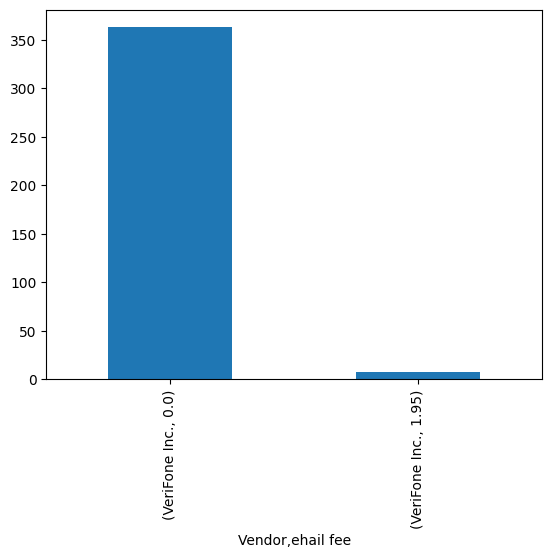

In [187]:
def plot_ehail_fee(df: pd.DataFrame):
    df.groupby(['Vendor'])['ehail fee'].value_counts().plot(kind='bar')
    plt.show()
plot_ehail_fee(trip_df)

- The next two functions show the relation between the extra amount, payment type, and the rate type and plot these relations as shown in the following bar graph. We find that the extra amount is greatest when the trip is paid using credit card and the rate type is standard.

In [188]:
def get_extra(df: pd.DataFrame):
    return df.groupby(['payment type', 'Rate type'])['extra'].sum()
extra_sum = get_extra(trip_df)
extra_sum

payment type  Rate type            
Cash          Group ride                    0.00
              JFK                         315.00
              Nassau or Westchester        41.50
              Negotiated fare               0.00
              Newark                       19.00
              Standard rate             79821.00
Credit card   JFK                         535.50
              Nassau or Westchester        86.50
              Negotiated fare               0.00
              Newark                       27.50
              Standard rate            110978.72
Dispute       JFK                           4.50
              Negotiated fare               0.00
              Newark                        0.50
              Standard rate                 1.50
No charge     JFK                          -4.50
              Nassau or Westchester         0.00
              Negotiated fare               0.00
              Newark                        4.50
              Standard rate      

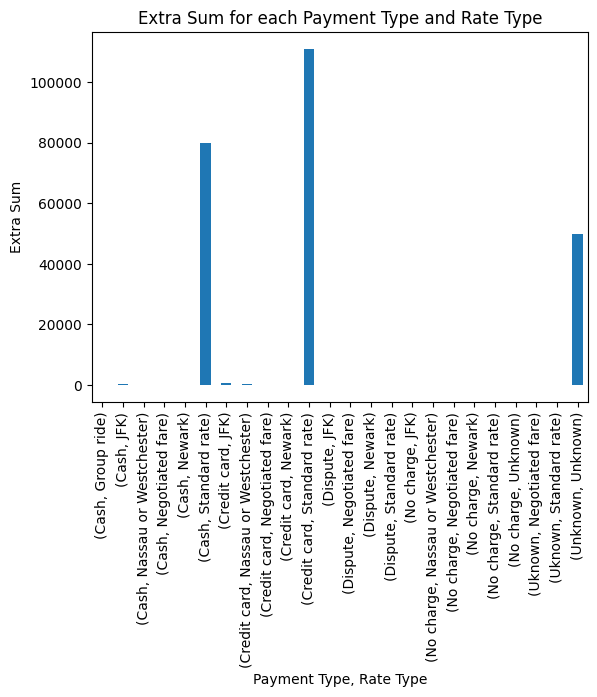

In [189]:
def plot_extra_sum(df):
    df.groupby(['payment type', 'Rate type'])['extra'].sum().plot(kind='bar', stacked=True)
    plt.xlabel('Payment Type, Rate Type')
    plt.ylabel('Extra Sum')
    plt.title('Extra Sum for each Payment Type and Rate Type')
    plt.show()

# Call the function with your DataFrame
plot_extra_sum(trip_df)

- The next two functions return the value count of the passengers and plot a bar graph showing the value counts of each passenger count. We find that 4 records have a passenger count 333 which is not normal. Moreover, we find that most of the trips have 1 passenger.

In [190]:
def get_passenger_value_counts(df: pd.DataFrame, col: str):
    return df[col].value_counts()
get_passenger_value_counts(trip_df, "passenger count")



passenger count
1.0      559200
2.0       50146
5.0       22350
6.0       10423
3.0        9477
4.0        3401
8.0          14
7.0          13
333.0         4
9.0           2
Name: count, dtype: int64

Text(0, 0.5, 'Count')

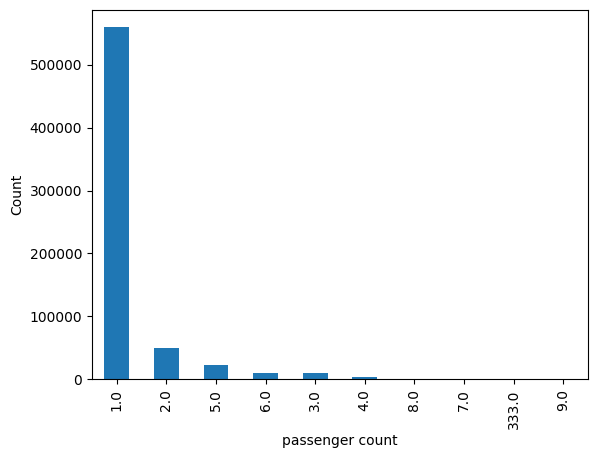

In [191]:
def plot_passenger_count(df: pd.DataFrame):
    return df['passenger count'].value_counts().plot(kind='bar')
plot_passenger_count(trip_df).set_xlabel("Passenger Count")
plot_passenger_count(trip_df).set_ylabel("Count")

- The next two functions return the value counts of the trip types and plot a bar graph showing the value counts. We find the most of the trips have a trip type Street-hail.

In [192]:
def get_triptype_count(df: pd.DataFrame, col: str):
    return df[col].value_counts()
get_triptype_count(trip_df, 'trip type')

trip type
Street-hail    624268
Dispatch        31513
Unknown         17516
Name: count, dtype: int64

Text(0, 0.5, 'Count')

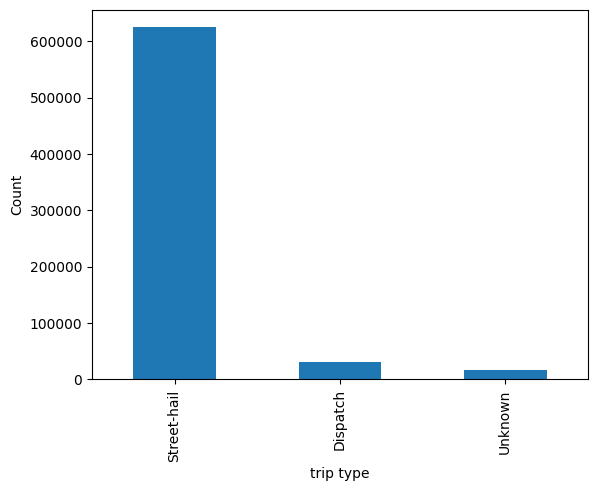

In [193]:
def plot_triptype_count(df: pd.DataFrame, col: str):
    return df[col].value_counts().plot(kind='bar')
plot_triptype_count(trip_df, 'trip type')
plot_triptype_count(trip_df, 'trip type').set_ylabel("Count")

- The next two functions show the average fare amount for every trip type and plot the relation between the trip type and the average fare amount. We find that the unkown trips have the greatest average fare amount although the unknown is not frequent in the dataset, followed by dispatch and finally street-hail.

In [194]:
def groupby_triptype_amount(df: pd.DataFrame):
    return df.groupby(['trip type'])['fare amount'].mean()
groupby_triptype_amount(trip_df)

trip type
Dispatch       25.410177
Street-hail    13.864088
Unknown        40.932794
Name: fare amount, dtype: float64

Text(0, 0.5, 'Average Fare Amount')

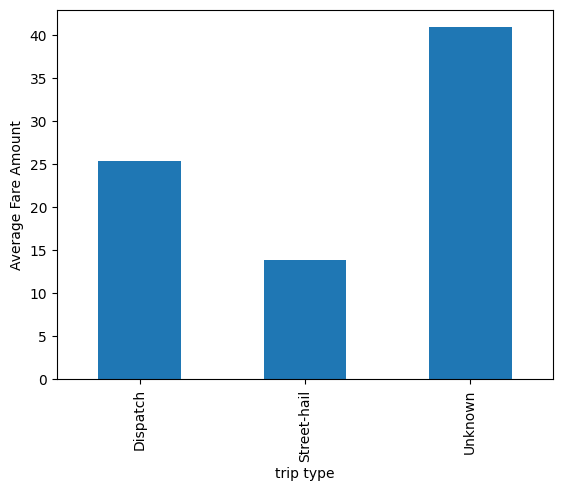

In [195]:
def plot_groupby_triptype_amount(df: pd.DataFrame):
    return df.groupby(['trip type'])['fare amount'].mean().plot(kind='bar')
plot_groupby_triptype_amount(trip_df)
plot_groupby_triptype_amount(trip_df).set_ylabel("Average Fare Amount")

- The next two functions create 5 bins for the fare amount to determine which range is more frequent in terms of fare amount and then plot a histogram showing the frequency for each range. We find that most of the fare amount values are between -100 and 37.1, then less value counts for fare amounts between 37.1 and 174.2, and finally few values greater thab 174.2 which could be outliers. The conclusion is that the majority of the fare amounts are not very high.

In [196]:
def get_total_amount_frequency_distribution(df: pd.DataFrame, col: str):
    range = []
    max = df[col].max()
    min = df[col].min()
    classes = 5
    width = (max - min + 1) / classes
    i = 0
    while i < classes:
        range.append(min + i * width)
        i += 1
    return trip_df.groupby(pd.cut(df[col], range)).count()[col]  
get_total_amount_frequency_distribution(trip_df, "fare amount")

fare amount
(-100.0, 37.1]    624727
(37.1, 174.2]      48506
(174.2, 311.3]        52
(311.3, 448.4]         5
Name: fare amount, dtype: int64

(array([6.23575e+05, 4.96590e+04, 5.20000e+01, 5.00000e+00, 6.00000e+00]),
 array([-100. ,   36.9,  173.8,  310.7,  447.6,  584.5]),
 <BarContainer object of 5 artists>)

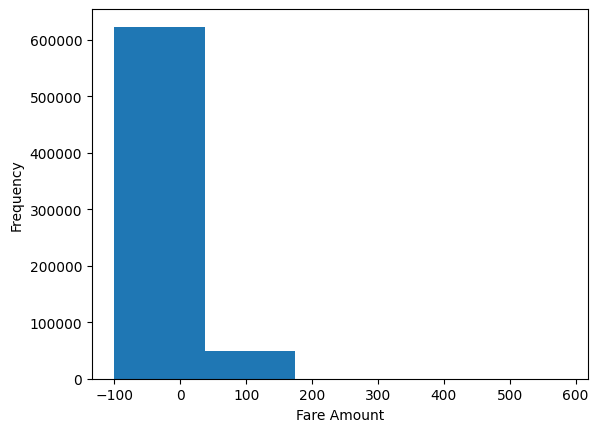

In [197]:
def plot_total_amount_frequency_distribution(df: pd.DataFrame, col):
    plot = plt.hist(col, data=df, bins=5, rwidth=(df[col].max() - df[col].min() + 1) / 5)
    plt.xlabel("Fare Amount")
    plt.ylabel("Frequency")
    return plot
plot_total_amount_frequency_distribution(trip_df, "fare amount")

- Ths next two functions return the null percentage for each attribute and then plots a bar graph showing these percentages.

In [198]:
def get_isnull_mean(df: pd.DataFrame):
    return df.isnull().mean()
get_isnull_mean(trip_df)

Vendor                   0.000000
lpep pickup datetime     0.000000
lpep dropoff datetime    0.000000
store and fwd flag       0.025461
Rate type                0.000000
PU Location              0.000000
DO Location              0.000000
passenger count          0.027131
trip distance            0.000000
fare amount              0.000000
extra                    0.557815
mta tax                  0.000000
tip amount               0.000000
tolls amount             0.000000
ehail fee                0.999449
improvement surcharge    0.000000
total amount             0.000000
payment type             0.023856
trip type                0.000000
congestion surcharge     1.000000
dtype: float64

<Axes: >

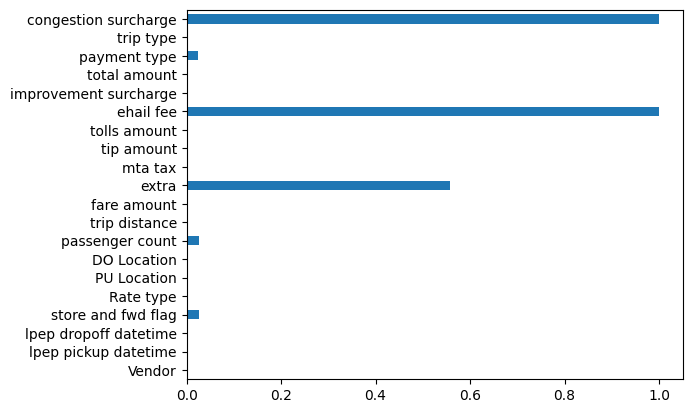

In [199]:
def plot_isnull_mean(df: pd.DataFrame):
    return df.isnull().mean().plot.barh()
plot_isnull_mean(trip_df)

- This function returns the unique values for all attributes that have less than 10 unique values. This function is important because it shows the types of vendors, rate type, mta tax value and so on.

In [200]:
def get_unique_type(df: pd.DataFrame):
    for col in df.columns:
        if(df[col].unique().size < 10):
            print("[" + col + "] = ", df[col].unique())
get_unique_type(trip_df)

[Vendor] =  ['VeriFone Inc.' 'Creative Mobile Technologies, LLC' 'Unknown']
[store and fwd flag] =  ['N' 'Y' nan]
[Rate type] =  ['Standard rate' 'Negotiated fare' 'JFK' 'Nassau or Westchester' 'Newark'
 'Group ride' 'Unknown']
[mta tax] =  [ 0.5   0.   -0.5   0.08]
[ehail fee] =  [ nan 0.   1.95]
[improvement surcharge] =  [ 0.3  0.  -0.3]
[payment type] =  ['Credit card' 'Cash' nan 'Dispute' 'No charge' 'Uknown' 'Unknown']
[trip type] =  ['Street-hail' 'Dispatch' 'Unknown']
[congestion surcharge] =  [nan]


- The next two functions return the value counts of each payment type and plot a bar graph showing these value counts. We find that most of the trips are paid using a credit card and that could be related to the extra amount.

In [201]:
def get_unique_value_counts(df: pd.DataFrame, col: str):
    return df[col].value_counts()
get_unique_value_counts(trip_df, 'payment type')

payment type
Credit card    390764
Cash           245625
Unknown         17143
No charge        2571
Dispute          1117
Uknown             15
Name: count, dtype: int64

<Axes: xlabel='payment type'>

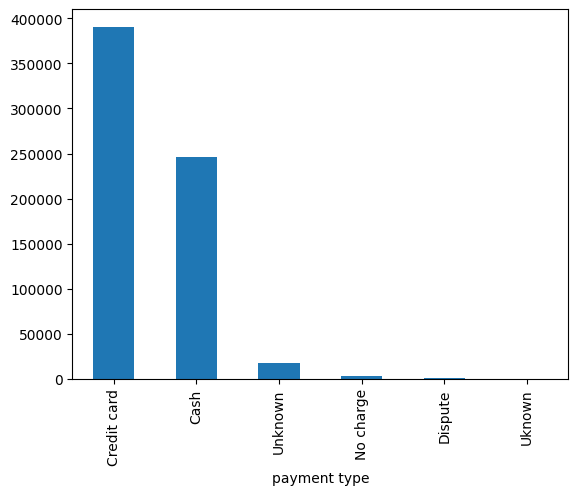

In [202]:
def plot_unique_value_counts(df: pd.DataFrame, col: str):
    return df[col].value_counts().plot(kind='bar')
plot_unique_value_counts(trip_df, 'payment type')

- The next two functions return the value count of the fare types and plot a bar graph to show these value counts. We find that most of a trips are standard rate trips. In general, like the payment type, the fare type could also be related to the extra amount.

In [203]:
def get_fare_type(df: pd.DataFrame):
    return df['Rate type'].value_counts()
get_fare_type(trip_df)

Rate type
Standard rate            622933
Negotiated fare           31347
Unknown                   17145
JFK                        1140
Nassau or Westchester       473
Newark                      258
Group ride                    1
Name: count, dtype: int64

<Axes: xlabel='Rate type'>

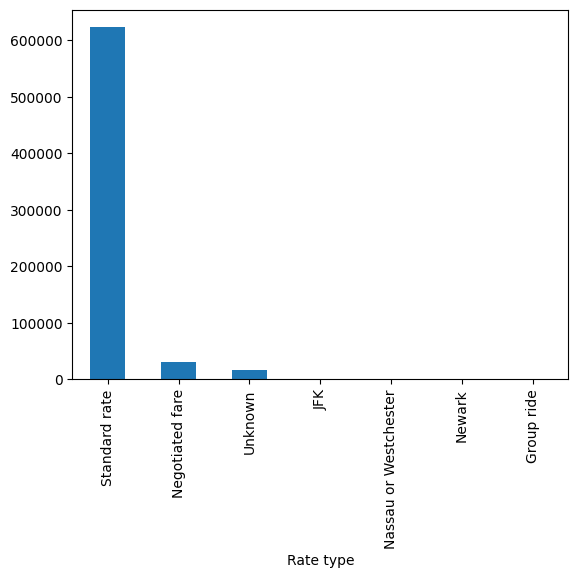

In [204]:
def plot_fare_type(df: pd.DataFrame):
    return df['Rate type'].value_counts().plot(kind='bar')
plot_fare_type(trip_df)

- The next two functions show which vendor has the greatest average fare amount and plot this relation using a bar graph. We find that unknown has the greatest average fare amount, followed by Creative Mobile Technologies, LLC, and finally VeriFone Inc. with a little difference in the average fare amount.

In [205]:
def get_vendor_fare_amount(df: pd.DataFrame):
    return df.groupby(['Vendor'])['fare amount'].mean()
get_vendor_fare_amount(trip_df)

Vendor
Creative Mobile Technologies, LLC    13.309175
Unknown                              22.178000
VeriFone Inc.                        15.418158
Name: fare amount, dtype: float64

<Axes: xlabel='Vendor'>

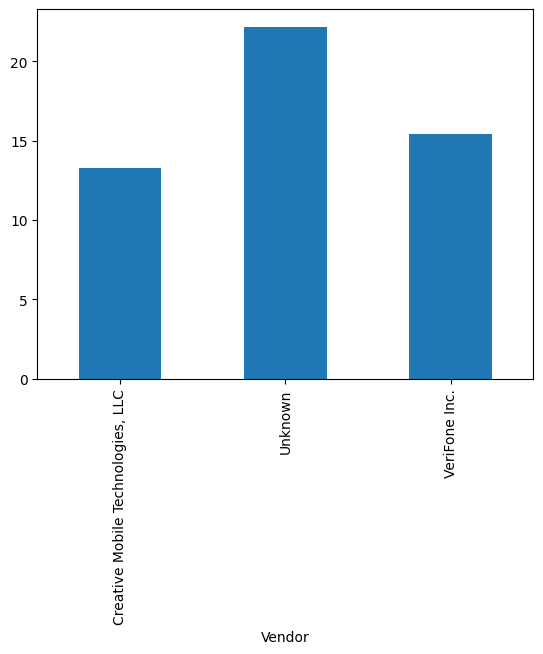

In [206]:
def plot_vendor_fare_amount(df: pd.DataFrame):
    return df.groupby(['Vendor'])['fare amount'].mean().plot(kind='bar')
plot_vendor_fare_amount(trip_df)

- The next two functions show the frequency distribution of the trip distance for each record in the data set and plot a histogram showing the frequency distribution. We find that the majorty of the distances is between 0 and 18.781 and that means that the rest of the values could be outliers.

In [207]:
def get_trip_distance_frequency_distribution(df: pd.DataFrame, col: str):
    range = []
    max = df[col].max()
    min = df[col].min()
    classes = 7
    width = (max - min + 1) / classes
    i = 0
    while i < classes:
        range.append(min + i * width)
        i += 1
    return trip_df.groupby(pd.cut(df[col], range)).count()[col]
get_trip_distance_frequency_distribution(trip_df, "trip distance")

trip distance
(0.0, 18.781]        655462
(18.781, 37.563]       9644
(37.563, 56.344]         81
(56.344, 75.126]         13
(75.126, 93.907]          2
(93.907, 112.689]         1
Name: trip distance, dtype: int64

(array([6.63214e+05, 9.97900e+03, 8.70000e+01, 1.20000e+01, 3.00000e+00,
        1.00000e+00, 1.00000e+00]),
 array([  0.        ,  18.63857143,  37.27714286,  55.91571429,
         74.55428571,  93.19285714, 111.83142857, 130.47      ]),
 <BarContainer object of 7 artists>)

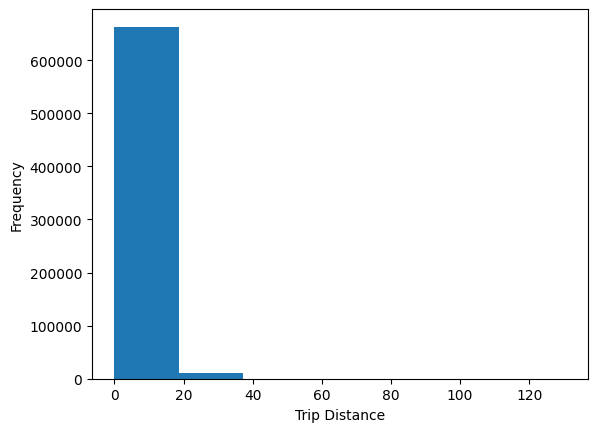

In [208]:
def plot_trip_distance_frequency_distribution(df: pd.DataFrame, col):
    plot = plt.hist(col, data=df, bins=7, rwidth=(df[col].max() - df[col].min() + 1) / 7)
    plt.xlabel("Trip Distance")
    plt.ylabel("Frequency")
    return plot
plot_trip_distance_frequency_distribution(trip_df, "trip distance")

# 3 - Cleaning Data

## Tidying up column names

- This function renames the columns by replacing all capital letters with small letters and replacing all spaces with underscore(_).

In [209]:
def rename_columns(df):
    df.columns = df.columns.str.lower()
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df
rename_columns(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.5,0.5,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.0,0.5,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.5,0.5,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.5,0.5,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.0,0.5,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673292,"Creative Mobile Technologies, LLC",2018-11-14 11:40:16,2018-11-14 11:50:00,N,Standard rate,"Manhattan,Morningside Heights","Manhattan,Upper West Side South",1.0,2.00,9.0,NaN,0.5,1.95,0.00,NaN,0.3,11.75,Credit card,Street-hail,NaN
673293,"Creative Mobile Technologies, LLC",2018-11-03 22:16:35,2018-11-03 22:42:37,N,Standard rate,"Brooklyn,Boerum Hill","Manhattan,Meatpacking/West Village West",3.0,5.10,21.0,0.5,0.5,4.45,0.00,NaN,0.3,26.75,NaN,Street-hail,NaN
673294,VeriFone Inc.,2018-11-16 11:26:54,2018-11-16 11:48:16,N,Standard rate,"Queens,Steinway","Queens,JFK Airport",1.0,13.51,37.0,NaN,0.5,7.56,0.00,NaN,0.3,45.36,Credit card,Street-hail,NaN
673295,VeriFone Inc.,2018-11-26 10:45:38,2018-11-26 10:53:49,N,Standard rate,"Manhattan,Morningside Heights","Manhattan,East Harlem South",1.0,1.07,7.0,NaN,0.5,1.56,0.00,NaN,0.3,9.36,Credit card,Street-hail,NaN


## Handle inconsistent data

- Detecting duplicates and rempving them is one of the crucial steps in cleaning the data because the existance of duplicates could ruin the analysis. Therefore, the following functions are used to detect the duplicates and remove them from the dataset. There were 5 duplicates in the whole dataset and the number of rows were 673297.

In [210]:
def get_duplicates(df):
    return df.duplicated().sum()
get_duplicates(trip_df)

5

In [211]:
def drop_duplicates(df: pd.DataFrame):
    return df.drop_duplicates()
trip_df = drop_duplicates(trip_df)


- Here we call the function again to verify that the duplicates are removed. The function this time returned 0 instead of 5.

In [212]:
get_duplicates(trip_df)

0

- Here we are verifying that the duplicates are dropped because the number of rows has been changed from 673297 to 673292

In [213]:
trip_df.shape[0]

673292

- After exploring the data, we found that almost all of the numeric attributes related to money have negative values. As we all know, money can't have a negative value so the negative values are incorrect data and must be handled. The negative values were replaced by their absolute values because replacing by zero will give inorrect data that might ruin the analysis. The following functions observe the records having negative values and correct them as explained. There were 1846 records in the dataset that have negative values.

In [214]:
def filter_negative_values(df: pd.DataFrame):
    # Select numeric value columns
    numeric_cols = ['total_amount', 'fare_amount', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 'ehail_fee', 'improvement_surcharge', 'congestion_surcharge', 'passenger_count', 'trip_distance']
    numeric_df = df[numeric_cols]
    
    # Check for negative values
    has_negative = (numeric_df < 0).any(axis=1)
    
    # Return subset of DataFrame with negative values
    if has_negative.any():
        return df[has_negative]
    else:
        return "No negative values found"
filter_negative_values(trip_df)    

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
382,VeriFone Inc.,2018-11-01 00:42:25,2018-11-01 00:55:39,N,Standard rate,"Queens,Forest Hills","Queens,Forest Hills",1.0,0.25,-9.00,-0.50,-0.5,0.0,0.0,NaN,-0.3,-10.3,Dispute,Street-hail,NaN
388,VeriFone Inc.,2018-11-01 00:49:13,2018-11-01 00:52:31,N,Standard rate,"Queens,Astoria","Queens,Astoria",1.0,0.68,-4.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-5.8,No charge,Street-hail,NaN
749,VeriFone Inc.,2018-11-01 01:55:25,2018-11-01 01:55:55,N,Standard rate,"Queens,Elmhurst","Queens,Elmhurst",4.0,0.04,-2.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-3.8,Dispute,Street-hail,NaN
777,VeriFone Inc.,2018-11-01 01:30:17,2018-11-01 01:30:47,N,Standard rate,"Queens,Jackson Heights","Queens,Jackson Heights",2.0,0.11,-2.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-3.8,Dispute,Street-hail,NaN
1589,VeriFone Inc.,2018-11-01 03:18:22,2018-11-01 03:23:13,N,Standard rate,"Bronx,Melrose South","Bronx,Mott Haven/Port Morris",1.0,0.89,-5.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-6.8,No charge,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655526,VeriFone Inc.,2018-11-30 23:43:21,2018-11-30 23:44:14,N,Standard rate,"Queens,Jamaica","Queens,Jamaica",1.0,0.14,-3.00,-0.50,-0.5,0.0,0.0,NaN,-0.3,-4.3,Dispute,Street-hail,NaN
655590,VeriFone Inc.,2018-11-30 23:36:07,2018-11-30 23:36:24,N,Standard rate,"Manhattan,Central Harlem","Manhattan,Central Harlem",1.0,0.03,-2.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-3.8,No charge,Street-hail,NaN
655736,VeriFone Inc.,2018-11-30 23:49:57,2018-11-30 23:51:07,N,Standard rate,"Brooklyn,Boerum Hill","Brooklyn,Fort Greene",1.0,0.01,-3.00,-0.50,-0.5,0.0,0.0,NaN,-0.3,-4.3,No charge,Street-hail,NaN
656055,VeriFone Inc.,2018-11-30 23:15:54,2018-11-30 23:17:30,N,Standard rate,"Brooklyn,Carroll Gardens","Brooklyn,Columbia Street",5.0,0.49,-3.50,-0.50,-0.5,0.0,0.0,NaN,-0.3,-4.8,No charge,Street-hail,NaN


In [215]:
def correct_negative_values(df: pd.DataFrame):
    for col in trip_df.columns:
        if(df[col].dtype == 'float64'):
            df[col] = df[col].abs()    
    return df
correct_negative_values(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.5,0.5,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.0,0.5,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.5,0.5,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.5,0.5,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.0,0.5,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673287,VeriFone Inc.,2018-12-01 00:23:25,2018-12-01 00:24:47,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.0,0.5,0.5,0.00,0.00,NaN,0.3,4.30,Cash,Street-hail,NaN
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.0,0.5,0.5,0.00,0.00,NaN,0.3,22.30,Cash,Street-hail,NaN
673289,VeriFone Inc.,2018-12-01 00:21:03,2018-12-01 00:30:15,N,Standard rate,"Brooklyn,Stuyvesant Heights","Brooklyn,Stuyvesant Heights",1.0,1.55,8.0,0.5,0.5,1.86,0.00,NaN,0.3,11.16,Credit card,Street-hail,NaN
673290,VeriFone Inc.,2018-12-01 00:15:56,2018-12-01 00:23:26,N,Standard rate,"Manhattan,East Harlem South","Manhattan,Upper East Side North",2.0,1.32,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,Credit card,Street-hail,NaN


- Here we call this function again to verify that all negative values are removed.

In [216]:
filter_negative_values(trip_df)

'No negative values found'

- After exploring the data, we observe that the payment type has six categories excluding the nan value and two of them represent the unknown value. However, we notice that it is represented in two ways: "Unknown" and "Uknown", therefore, we must stick to one of them in order to make the data consistent. "Uknown" is an inconsistency because the unknown values in the other attributes have the value "Unknown". Therefore, the below function corrects this mistake by replacing "Uknown" with "Unknown".

In [217]:
get_unique_type(trip_df)

[vendor] =  ['VeriFone Inc.' 'Creative Mobile Technologies, LLC' 'Unknown']
[store_and_fwd_flag] =  ['N' 'Y' nan]
[rate_type] =  ['Standard rate' 'Negotiated fare' 'JFK' 'Nassau or Westchester' 'Newark'
 'Group ride' 'Unknown']


[extra] =  [0.5   nan 1.   4.5  0.72 2.75 5.5  8.25]
[mta_tax] =  [0.5  0.   0.08]
[ehail_fee] =  [ nan 0.   1.95]
[improvement_surcharge] =  [0.3 0. ]
[payment_type] =  ['Credit card' 'Cash' nan 'Dispute' 'No charge' 'Uknown' 'Unknown']
[trip_type] =  ['Street-hail' 'Dispatch' 'Unknown']
[congestion_surcharge] =  [nan]


In [218]:
def correct_uknown_payment_type(df: pd.DataFrame):
    df['payment_type'].replace("Uknown", "Unknown", inplace=True)
    return df
correct_uknown_payment_type(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.5,0.5,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.0,0.5,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.5,0.5,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.5,0.5,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.0,0.5,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673287,VeriFone Inc.,2018-12-01 00:23:25,2018-12-01 00:24:47,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.0,0.5,0.5,0.00,0.00,NaN,0.3,4.30,Cash,Street-hail,NaN
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.0,0.5,0.5,0.00,0.00,NaN,0.3,22.30,Cash,Street-hail,NaN
673289,VeriFone Inc.,2018-12-01 00:21:03,2018-12-01 00:30:15,N,Standard rate,"Brooklyn,Stuyvesant Heights","Brooklyn,Stuyvesant Heights",1.0,1.55,8.0,0.5,0.5,1.86,0.00,NaN,0.3,11.16,Credit card,Street-hail,NaN
673290,VeriFone Inc.,2018-12-01 00:15:56,2018-12-01 00:23:26,N,Standard rate,"Manhattan,East Harlem South","Manhattan,Upper East Side North",2.0,1.32,7.0,0.5,0.5,0.00,0.00,NaN,0.3,8.30,Credit card,Street-hail,NaN


- Here we verify that all "Uknown"(s) are replaced. The attribute payment_type doesn't have "Uknown" as a unique value anymore.

In [219]:
get_unique_type(trip_df)

[vendor] =  ['VeriFone Inc.' 'Creative Mobile Technologies, LLC' 'Unknown']
[store_and_fwd_flag] =  ['N' 'Y' nan]
[rate_type] =  ['Standard rate' 'Negotiated fare' 'JFK' 'Nassau or Westchester' 'Newark'
 'Group ride' 'Unknown']
[extra] =  [0.5   nan 1.   4.5  0.72 2.75 5.5  8.25]
[mta_tax] =  [0.5  0.   0.08]
[ehail_fee] =  [ nan 0.   1.95]
[improvement_surcharge] =  [0.3 0. ]
[payment_type] =  ['Credit card' 'Cash' nan 'Dispute' 'No charge' 'Unknown']
[trip_type] =  ['Street-hail' 'Dispatch' 'Unknown']
[congestion_surcharge] =  [nan]


- Here we observe that some records have pickup dates that are not in 11/2018. These records are out of scope of the analysis because this dataset should only includde the trips conducted in 11/2018. These records might have been entered in this dataset my mistake and they should belong to another dataset according to their dates. Therefore, the most appropraite solution is to remove these records from the dataset. The following functions observe the incorrectness and deal with it.

In [220]:
def get_incorrect_lpep_pickup_datetime(df: pd.DataFrame):
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    return df[(df['lpep_pickup_datetime'].dt.year != 2018) | (df['lpep_pickup_datetime'].dt.month != 11)]
get_incorrect_lpep_pickup_datetime(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
82,VeriFone Inc.,2018-10-31 23:59:49,2018-11-01 00:00:13,N,Standard rate,"Brooklyn,Gowanus","Brooklyn,Gowanus",1.0,0.01,2.5,0.5,0.5,0.00,0.0,NaN,0.3,3.80,Cash,Street-hail,NaN
101,VeriFone Inc.,2018-10-31 23:57:59,2018-11-01 00:04:08,N,Standard rate,"Queens,Astoria","Queens,Astoria",2.0,0.92,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,Cash,Street-hail,NaN
118,VeriFone Inc.,2018-10-31 23:15:41,2018-10-31 23:18:08,N,Standard rate,"Brooklyn,Cobble Hill","Brooklyn,Carroll Gardens",1.0,0.90,4.5,0.5,0.5,1.16,0.0,NaN,0.3,6.96,Credit card,Street-hail,NaN
171,VeriFone Inc.,2018-10-31 00:29:49,2018-10-31 00:44:24,N,Standard rate,"Queens,Flushing","Queens,Jackson Heights",1.0,2.98,13.0,0.5,0.5,0.00,0.0,NaN,0.3,14.30,Credit card,Street-hail,NaN
175,VeriFone Inc.,2018-10-31 19:38:41,2018-10-31 19:48:23,N,Standard rate,"Manhattan,East Harlem South","Manhattan,Upper East Side South",1.0,2.31,10.0,0.5,0.5,0.00,0.0,NaN,0.3,11.30,Cash,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
656097,VeriFone Inc.,2018-12-01 00:00:06,2018-12-01 00:11:26,N,Standard rate,"Brooklyn,Greenpoint","Brooklyn,Williamsburg (South Side)",5.0,1.52,9.0,0.5,0.5,2.06,0.0,NaN,0.3,12.36,Credit card,Street-hail,NaN
656130,VeriFone Inc.,2018-12-01 00:00:16,2018-12-01 00:09:20,N,Standard rate,"Manhattan,Central Harlem North","Manhattan,Central Harlem North",1.0,1.32,6.5,0.5,0.5,0.00,0.0,NaN,0.3,7.80,Cash,Street-hail,NaN
673287,VeriFone Inc.,2018-12-01 00:23:25,2018-12-01 00:24:47,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,3.0,0.5,0.5,0.00,0.0,NaN,0.3,4.30,Cash,Street-hail,NaN
673289,VeriFone Inc.,2018-12-01 00:21:03,2018-12-01 00:30:15,N,Standard rate,"Brooklyn,Stuyvesant Heights","Brooklyn,Stuyvesant Heights",1.0,1.55,8.0,0.5,0.5,1.86,0.0,NaN,0.3,11.16,Credit card,Street-hail,NaN


In [221]:
def correct_lpep_pickup_datetime(df: pd.DataFrame):
    df.drop(df[(df['lpep_pickup_datetime'].dt.year != 2018) | (df['lpep_pickup_datetime'].dt.month != 11)].index, inplace=True)
    return df
correct_lpep_pickup_datetime(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,NaN,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",NaN,25.25,0.00,2.75,0.5,0.00,5.76,NaN,0.0,0.00,Unknown,Unknown,NaN
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,NaN,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",NaN,6.01,43.25,2.75,0.5,0.00,0.00,NaN,0.0,46.50,Unknown,Unknown,NaN
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,NaN,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",NaN,22.77,0.00,2.75,0.5,0.00,0.00,NaN,0.0,0.00,Unknown,Unknown,NaN
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,NaN,0.3,22.30,Cash,Street-hail,NaN


- If you look at the result above, you will notice that the number of columns has been changed from 673292 to 673184.
- Here we vereify that all the incorrect dates are removed. We can see that calling the function again returned an empty table.

In [222]:
get_incorrect_lpep_pickup_datetime(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge


- After exploring the data, we notice that the passenger count value for 4 records was 333. This value is certainly an incorrect value and not an outlier because it is impossible that 333 persons ride the same taxi or the same van. There is an assumption that these values in reality are 3 not 333 and they were wrongly typed by the person entering these data. Therefore, the best way to deal with this noise or incorrectness is to raplace all passenger counts having the value 333 with 3 which makes much more sense as 3 is a normal number of a passenger count. The following functions correct the error and after observing the it.

In [223]:
get_passenger_value_counts(trip_df, "passenger_count")

passenger_count
1.0      559114
2.0       50127
5.0       22344
6.0       10422
3.0        9476
4.0        3401
8.0          14
7.0          13
333.0         4
9.0           2
Name: count, dtype: int64

In [224]:
def correct_passenger_count(df: pd.DataFrame):
    df['passenger_count'].replace(333, 3, inplace=True)
    return df
correct_passenger_count(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,NaN,0.3,3.80,Credit card,Street-hail,NaN
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,NaN,0.3,14.30,Cash,Street-hail,NaN
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,NaN,0.3,7.80,Cash,Street-hail,NaN
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,NaN,0.3,21.56,Credit card,Street-hail,NaN
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,NaN,0.3,7.56,Credit card,Street-hail,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,NaN,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",NaN,25.25,0.00,2.75,0.5,0.00,5.76,NaN,0.0,0.00,Unknown,Unknown,NaN
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,NaN,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",NaN,6.01,43.25,2.75,0.5,0.00,0.00,NaN,0.0,46.50,Unknown,Unknown,NaN
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,NaN,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",NaN,22.77,0.00,2.75,0.5,0.00,0.00,NaN,0.0,0.00,Unknown,Unknown,NaN
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,NaN,0.3,22.30,Cash,Street-hail,NaN


- Here we notice that the passenger count "333" doesn't exist anymore which is a verification of the above function.

In [225]:
get_passenger_value_counts(trip_df, "passenger_count")

passenger_count
1.0    559114
2.0     50127
5.0     22344
6.0     10422
3.0      9480
4.0      3401
8.0        14
7.0        13
9.0         2
Name: count, dtype: int64

## Handling Missing data

- This function returns the null percentage of the attribute given as a parameter to the function.
- This function will be used to observe the values and verify that the missing data is handled.

In [226]:
def observe_missing_values(df: pd.DataFrame, col: str):
    return df[col].isnull().mean() * 100

- One of the most interesting attributes is the conjestion surcharge because after exploring the data, it was found that 100% of the value of conjestion surcharge were null. The conjestion surcharge is MNAR (Missing Not At Random) because in 2018 there were no conjestion surcharges paid on taxi trips in New York. Conjestion surcharge started in 2019 so all the data records have the conjestion surcharge missing because all the records are in 11/2018.
- The best way to deal with those missing values is to impute with 0 because 0 means that nothing will be paid. Dropping the whole column was not the best solution because it may affect the analysis later on if this dataset is integrated with another dataset that has conjestion surcharge for the trips not null (maybe in 2019 or above).
- The following functions observe the percentage of the null values and handles the missing values.

In [227]:
observe_missing_values(trip_df, 'congestion_surcharge')

100.0

In [228]:
def impute_congestion_surcharge(df: pd.DataFrame):
    df['congestion_surcharge'].fillna(0.0, inplace=True)
    return df
impute_congestion_surcharge(trip_df)
update_lookup_table(lookup_table, 'congestion_surcharge', 'NaN', 0.0)

- Here we can see that the conjestion surcharge is no longer missing after imputing with 0.

In [229]:
observe_missing_values(trip_df, 'congestion_surcharge')

0.0

- After exploring the data, we find that 99.9% of the ehail fee values are missing which is almost 100% of the values. The ehail fees are MNAR (Missing Not At Random) because if the trip has an ehail fee of null, that means that the trip was not ehailed. It is MNAR because the missingness here is related to the missing data itself.
- Note that there are about 371 ehailed trips and that might be because VeriFone Inc. were testing ehailing services since all non-missing values are in VeriFone Inc. trips. 
- The best way to haandle the missing values is to impute with 0 because 0 will not affect the total amount. Dropping the column is not the best option here because this dataset could be integrated with another dataset that has ehailed trip.
- The following functions will handle the missing values and check whether the values are stilling or not.

In [230]:
observe_missing_values(trip_df, 'ehail_fee')

99.94488876740981

In [231]:
def impute_ehail_fee(df: pd.DataFrame):
    df['ehail_fee'].fillna(0, inplace=True)
    return df
impute_ehail_fee(trip_df)
update_lookup_table(lookup_table, 'ehail_fee', 'NaN', 0.0)

- Here we find that the ehail fee values are not missing any more which is a verification that the missing value are handled.

In [232]:
observe_missing_values(trip_df, 'ehail_fee')

0.0

- After exploring the data, we find that 55.7% of the trips don't have an extra included in the total amount (missing values). The extra amount in general could depend on the payment type of the trip or could depend on the rate type. 
- We conclude that the extra amount is MAR (Missing At Random) because the missingness depends on rate types. 
- If observe the extra relations with rate type, we find that the extra amount is missing for all records if the rate type is "Group ride" or "Negotiated fare". If the rate type is negotiated, the driver and the passengers could have agreed that the passengers will not pay an extra amount. 
- Moreover, we find that the extra is missing if the rate type is "Nassau or Westchester" and the payment type is "No charge". However, the relation of extra is stronger with the rate type than with the payment type.
- Based on these observations, the best way to deal with these missing values is to do the following:
    - If the extra amount median for a certain category is nan (Not a Number), we impute with 0 because they are missing in all records.
    - Otherwise, we will use the multi-variate imputation technique to fill in the missing values. We will impute with the median grouped by the rate type and payment type. We impute with the median because this value must be consistent for each rate type and trip type.
- The following functions observe the missing value percentage and the relation between the extra and the payment type and rate type once more and handle the missing values as explained.    

In [233]:
observe_missing_values(trip_df, 'extra')

55.7854910395969

In [234]:
def extra_relations(df: pd.DataFrame):
    return df.groupby(['payment_type', 'rate_type'])['extra'].median()
extra_relations(trip_df)

payment_type  rate_type            
Cash          Group ride                NaN
              JFK                      4.50
              Nassau or Westchester    0.50
              Negotiated fare           NaN
              Newark                   0.50
              Standard rate            0.50
Credit card   JFK                      4.50
              Nassau or Westchester    0.50
              Negotiated fare           NaN
              Newark                   1.00
              Standard rate            0.50
Dispute       JFK                      4.50
              Negotiated fare           NaN
              Newark                   0.50
              Standard rate            0.50
No charge     JFK                      4.50
              Nassau or Westchester     NaN
              Negotiated fare           NaN
              Newark                   0.75
              Standard rate            0.50
              Unknown                   NaN
Unknown       Negotiated fare           

In [235]:
#fill in the missing values of extra with the mean grouped by payment_type and rate_type
def impute_extra(df: pd.DataFrame):
    # loop the rows group by payment_type and rate_type
    # for each group calculate the median of extra
    # fill the missing values in extra with the median
    # if there is no median (all values are NaN) fill with 0
    df['extra'].fillna(df.groupby(['payment_type', 'rate_type'])['extra'].transform('median'), inplace=True)
    df['extra'].fillna(0, inplace=True)
    
    return df
impute_extra(trip_df)


,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,NaN,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",NaN,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,NaN,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",NaN,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,NaN,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",NaN,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we verify that the extra is imputed in two ways:
    - First, we see that the null percentage became 0.
    - We also see in the relations that the median became 0 instead of nan for some categories.

In [236]:
observe_missing_values(trip_df, 'extra')

0.0

In [237]:
extra_relations(trip_df)

payment_type  rate_type            
Cash          Group ride               0.00
              JFK                      4.50
              Nassau or Westchester    0.50
              Negotiated fare          0.00
              Newark                   0.50
              Standard rate            0.50
Credit card   JFK                      4.50
              Nassau or Westchester    0.50
              Negotiated fare          0.00
              Newark                   1.00
              Standard rate            0.50
Dispute       JFK                      4.50
              Negotiated fare          0.00
              Newark                   0.50
              Standard rate            0.50
No charge     JFK                      4.50
              Nassau or Westchester    0.00
              Negotiated fare          0.00
              Newark                   0.75
              Standard rate            0.50
              Unknown                  0.00
Unknown       Negotiated fare          0

- We find that abount 2.3% of the trip records have the payment type missing. It is MCAR (Missing completely At Random) because we can't find a pattern for the missingness of the data in that case. It could be missing due to technical issues that doesn't have any relation with the type of data.
- Since the missingness percentage is small (2%-3%), the best way to deal with this is to impute with the mode because the payment type is a categorical feature. Dropping the rows would not be the best option because we want to maintain the whole data so that it doesn't affect the analysis
- The following functions will observe the missingness percentage and impute with the mode.

In [238]:
observe_missing_values(trip_df, 'payment_type')

2.385974711223083

In [240]:
def impute_payment_type(df: pd.DataFrame):
    mode = df['payment_type'].mode()[0]
    df['payment_type'].fillna(mode, inplace=True)
    update_lookup_table(lookup_table, 'payment_type', 'None', mode)
    return df
impute_payment_type(trip_df)


,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,NaN,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",NaN,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,NaN,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",NaN,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,NaN,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",NaN,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we find that the payment type is not missing anymore.

In [241]:
observe_missing_values(trip_df, 'payment_type')

0.0

- After exploring the data, we find that the passenger count for some trips is missing by 2.7%. It is MCAR (Missing Completely At Random) because there are no patterns for the missingness of the data in this case. The data could be missing due to technical issues that doesn't depend on the data itself.
- The best way to deal with this is to impute with the median, because the median in this case gets the most frequent value of the passenger count. Imputing with the mean in this case could return a decimal value which can't represent a value for the passenger count. Moreover, dropping the rows is also not the best solution because the dataset is not small in this case and it could affect the analysis.
- The following functions observe and handle the missing values.

In [242]:
observe_missing_values(trip_df, 'passenger_count')

2.7135226030327515

In [244]:
def impute_null_passenger_count(df: pd.DataFrame):
    mode = df['passenger_count'].mode()[0]
    df['passenger_count'].fillna(mode, inplace=True)
    update_lookup_table(lookup_table, 'passenger_count', 'NaN', mode)
    return df 
impute_null_passenger_count(trip_df)


,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,NaN,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,NaN,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,NaN,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we verify that the missing data is handled because the percentage of missingness became 0%.

In [245]:
observe_missing_values(trip_df, 'passenger_count')

0.0

- After exploring the data, we find that the store and forward flag for some trips is missing by 2.5%. It is MCAR (Missing Completely At Random) because there are no patterns for the missingness of the data in this case. The data could be missing due to technical issues that doesn't depend on the data itself.
- The best way to deal with this is to impute with the mode, because the store and forward flag is a categorical feature.
- The following functions observe and handle the missing values.

In [246]:
observe_missing_values(trip_df, 'store_and_fwd_flag')

2.5465548794980273

In [248]:
def impute_store_and_fwd_flag(df: pd.DataFrame):
    mode = df['store_and_fwd_flag'].mode()[0]
    df['store_and_fwd_flag'].fillna(mode, inplace=True)
    update_lookup_table(lookup_table, 'store_and_fwd_flag', 'None', mode)
    return df
impute_store_and_fwd_flag(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we observe that the missingness of store and forward flag is handled.

In [249]:
observe_missing_values(trip_df, 'store_and_fwd_flag')

0.0

## Findings and conclusions

- All comments are discussed while handling the inconsistencies, the incorrect data, and the missing values.
- The dataset had some incorrect and inconsistent values in multiple attributes, but they are finally handled.
- Handling these errors will help handling missing values and outliers if we imputed with existing values like mean, mode, median and so on.
- The dataset also had some attributes with missing values, but they were handles.
- Handling these values will help in outlier detection and handling.

## Handling outliers

- Here we observe the outliers by checking the value that are less 4 standard deviations from the mean or higher than 4 standard deviations from the mean. I chose 4 standard deviations in this case to include passenger counts from 1 to 5 because the maximum number of passengers that can ride a taxi in New York is 5, so any value higher than 5 must be considered an outlier.
- The best way to get rid of these outliers is to with the median excluding the outlier while calculating the median. Since the passenger count 1 is very very frequent. The median and the mode are similar in this case.
- The following functions observe the outliers and handle them.

In [250]:
def detect_passenger_count_outliers(df: pd.DataFrame):
    lower = df['passenger_count'].mean() - 4 * df['passenger_count'].std()
    upper = df['passenger_count'].mean() + 4 * df['passenger_count'].std()
    df = df[(df['passenger_count'] < lower) | (df['passenger_count'] > upper)]
    print("Number of outliers: ", len(df))
    print(lower, upper)
detect_passenger_count_outliers(trip_df)    

Number of outliers:  10451
-2.6487483197420736 5.305234510738888


In [251]:
def correct_passenger_count_outliers(df: pd.DataFrame):
    lower = df['passenger_count'].mean() - 4 * df['passenger_count'].std()
    upper = df['passenger_count'].mean() + 4 * df['passenger_count'].std()
    df_new = df[(df['passenger_count'] > lower) & (df['passenger_count'] < upper)]
    median = df_new['passenger_count'].median()
    df['passenger_count'] = df['passenger_count'].apply(lambda x: median if (x < lower or x > upper) else x)
    return df
correct_passenger_count_outliers(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- After exploring the data, we find that the mta tax has only 3 values in the dataset: 0, 0.5, 0.08. Moreover, most of the trips have mta tax of 0.5, and some have mta tax 0 (which means that there is no mta tax), and only 1 trip has an mta tax of 0.08. The 0.08 is considered an outlier because it is not a normal value of the mta tax, therefor, it must be removed.
- If we think of grouping or clustering these values, we will observe that all the 0.5 values will be in a cluster and all the 0 values will be in a cluster and the 0.08 will stand alone.
- The best way to handle this outlier is to impute with the median which is in this case 0.5.
- The outlier was detected in this case by removing all records having the mta tax equal 0.5. This is as if I am removing 1 cluster out of 3 clusters so I can detect the outlier value out of the remaining to clusters.
- The following functions do all the detection and handling explained above.

In [252]:
def detect_mta_tax_outlier(df: pd.DataFrame):
     median = df['mta_tax'].median()
     df_new = df[df['mta_tax'] != median]
     lower = df_new['mta_tax'].mean() - 4 * df_new['mta_tax'].std()
     upper = df_new['mta_tax'].mean() + 4 * df_new['mta_tax'].std()
     df_new = df_new[(df_new['mta_tax'] < lower) | (df_new['mta_tax'] > upper)]
     print("Number of outliers: ", len(df_new))
     print(lower, upper)
detect_mta_tax_outlier(trip_df)

Number of outliers:  1
-0.003178867953751459 0.0031947362469181752


In [253]:
def correct_mta_tax_outlier(df: pd.DataFrame):
    median = df['mta_tax'].median()
    df_new = df[df['mta_tax'] != median]
    lower = df_new['mta_tax'].mean() - 4 * df_new['mta_tax'].std()
    upper = df_new['mta_tax'].mean() + 4 * df_new['mta_tax'].std()
    df['mta_tax'] = df['mta_tax'].apply(lambda x: median if (x < lower or x > upper) else x)
    return df
correct_mta_tax_outlier(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.50,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.50,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.50,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.50,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.50,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,2.75,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,2.75,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,2.75,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.50,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- The outlier in the case of extra will be the values that are not normal or the value that are greater than 3 standard deviation or the values that are less than 3 standard deviations for each group (ex: payment type: "Cash" and rate type: "JFK") because the extra depends on the rate type and the payment type. 
- The best way to handle these outliers is to replace the outlier with the median of each group like we did with the missing values. As discussed before, the median here is the best solution because the unique extra values are not many so the mean will not be robust to the outliers in this case. Moreover, in almost all cases in this dataset, the median and mode are the same for all numeric attributes in the dataset.
- The following functions detect and handle the outliers.

In [254]:
def detect_extra_outliers(df: pd.DataFrame):
    rate_types = df['rate_type'].unique()
    payment_type = df['payment_type'].unique()
    for rate_type in rate_types:
        for payment in payment_type:
            df_temp = df[(df['rate_type'] == rate_type) & (df['payment_type'] == payment)]
            lower = df_temp['extra'].mean() - 3 * df_temp['extra'].std()
            upper = df_temp['extra'].mean() + 3 * df_temp['extra'].std()
            df_temp_outliers = df_temp[(df_temp['extra'] < lower) | (df_temp['extra'] > upper)]
            if (len(df_temp_outliers) > 0):
                print("Number of outliers for rate_type: ", rate_type, " and payment type: ", payment, "is: ", len(df_temp_outliers), " with percentage: ", len(df_temp_outliers) / len(df_temp) * 100, "%")
detect_extra_outliers(trip_df)

Number of outliers for rate_type:  JFK  and payment type:  Credit card is:  17  with percentage:  2.564102564102564 %
Number of outliers for rate_type:  Newark  and payment type:  Credit card is:  6  with percentage:  4.195804195804196 %


Number of outliers for rate_type:  Unknown  and payment type:  Unknown is:  1092  with percentage:  6.369946917109025 %


In [255]:
def correct_extra_outliers(df: pd.DataFrame):
    rate_types = df['rate_type'].unique()
    payment_type = df['payment_type'].unique()
    for rate_type in rate_types:
        for payment in payment_type:
            df_temp = df[(df['rate_type'] == rate_type) & (df['payment_type'] == payment)]
            lower = df_temp['extra'].mean() - 3 * df_temp['extra'].std()
            upper = df_temp['extra'].mean() + 3 * df_temp['extra'].std()
            median = df_temp['extra'].median()
            df['extra'] = df['extra'].apply(lambda x: median if (x < lower or x > upper) else x)
    return df
correct_extra_outliers(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,0.5,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,0.5,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,0.5,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we observe that the tips amount have outliers. We detect the outliers by checking the values that are less than 3 standard deviations and the values that are greater than three standard deviations because if a tips amount is greater than that it will be to big and not the normal that the people pay.
- The best way is to impute with the truncated mean (robust to outliers) value of tips amount for every payment type (Multi-variate Imputation). I came with this approach by writing a query that gets the mean of the tip amount for every payment type. As a result, I noticed that if the payment type is "Cash", no tips are paid. Moreover, if the payment type is "Credit card", the average amount of tips is the greatest.
- The following functions detect and handle the outliers for tips amount.

In [256]:
def detect_tip_amount_outliers(df: pd.DataFrame):
    lower = df['tip_amount'].mean() - 3 * df['tip_amount'].std()
    upper = df['tip_amount'].mean() + 3 * df['tip_amount'].std()
    df = df[(df['tip_amount'] < lower) | (df['tip_amount'] > upper)]
    print("Number of outliers: ", len(df))
    print(lower, upper)
detect_tip_amount_outliers(trip_df)

Number of outliers:  11624
-4.687966133480839 6.621514554120664


In [257]:
lower = trip_df['tip_amount'].mean() - 3 * trip_df['tip_amount'].std()
upper = trip_df['tip_amount'].mean() + 3 * trip_df['tip_amount'].std()
a = trip_df[(trip_df['tip_amount'] >= lower) & (trip_df['tip_amount'] <= upper)].groupby(['payment_type'])['tip_amount'].mean()
a

payment_type
Cash           0.000000
Credit card    1.364141
Dispute        0.005953
No charge      0.002205
Unknown        0.004309
Name: tip_amount, dtype: float64

In [258]:
def correct_tip_amount_outliers(df: pd.DataFrame):
    lower = df['tip_amount'].mean() - 3 * df['tip_amount'].std()
    upper = df['tip_amount'].mean() + 3 * df['tip_amount'].std()
    a = df[(df['tip_amount'] >= lower) & (df['tip_amount'] <= upper)].groupby(['payment_type'])['tip_amount'].mean()
    for col in a.index:
        a[col] = round(a[col], 1)
    df['tip_amount'] = df['tip_amount'].apply(lambda x: None if (x < lower or x > upper) else x)
    df['tip_amount'].fillna(df['payment_type'].map(a), inplace=True)
    return df
trip_df = correct_tip_amount_outliers(trip_df)

- Here we observe that tolls amount also has outliers. The outliers in this case are the values that are less than 3 standard deviations and the values that are greater than 3 standard deviations excluding the 0 before calculating the mean and standard deviation. I chose 3 standard deviations because there were frequent values like 5.76 and 2.56 so I want to keep those values. Also, the values that are greater than 3 standard deviations are not many in this dataset.
- The best way to deal with these outliers is to impute with the mode excluding the 0 values. We excluded the 0 values becasue they were too much. If we hadn't removed the 0 values, the mode would have been 0. However, this is what we want because the 0 value indicates that the taxi didn't cross certain bridges, tunnels, or highways, but the outliers indicate that the taxi crossed these areas so we don't want to replace with 0.
- The following functions detect and handle the outliers.

In [259]:
def detect_tolls_amount_outliers(df: pd.DataFrame): 
    df_new = df[df['tolls_amount'] != 0]
    series = df_new['tolls_amount']
    lower = series.mean() - 3 * series.std()
    upper = series.mean() + 3 * series.std()
    df_new = df_new[(series < lower) | (series > upper)]
    print("Number of outliers: ", len(df_new))
    print(lower, upper)
detect_tolls_amount_outliers(trip_df)

Number of outliers:  1194
0.11053024680126011 11.514387012475478


In [260]:
def correct_tolls_amount_outliers(df: pd.DataFrame):
    df_new = df[df['tolls_amount'] != 0]
    series = df_new['tolls_amount']
    lower = series.mean() - 3 * series.std()
    upper = series.mean() + 3 * series.std()
    mode = df_new['tolls_amount'].mode()
    df.loc[((df['tolls_amount'] < lower) | (df['tolls_amount'] > upper)) & (df['tolls_amount'] != 0), 'tolls_amount'] = mode[0]
    return df
correct_tolls_amount_outliers(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,25.25,0.00,0.5,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,0.5,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,0.5,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we find that the trip distance attribute has outlier. The outliers in this case are the values that are less that 5 standard deviations or values that are greater than 5 standard deviations. I chose 5 because 3 and 4 standard deviation produced many outlier which is not nice because if I replace a great number of record, the normal distribution could be destroyed.
- The best way to handle these outliers is to replace by the truncated mean (robust to outlier). I chose the mean in this case because there are many unique values so median or mode will not be the best option.
- The following functions detect and handle the outliers.

In [261]:
def detect_trip_distance_outliers(df: pd.DataFrame):
    lower = df['trip_distance'].mean() - 5 * df['trip_distance'].std()
    upper = df['trip_distance'].mean() + 5 * df['trip_distance'].std()
    df = df[(df['trip_distance'] < lower) | (df['trip_distance'] > upper)]
    print("Number of outliers: ", len(df))
    print(lower, upper)
detect_trip_distance_outliers(trip_df)

Number of outliers:  2305
-17.245747462143022 24.443257890198353


In [262]:
def correct_trip_distance_outliers(df: pd.DataFrame):
    lower = df['trip_distance'].mean() - 5 * df['trip_distance'].std()
    upper = df['trip_distance'].mean() + 5 * df['trip_distance'].std()
    df_new = df[(df['trip_distance'] >= lower) & (df['trip_distance'] <= upper)]
    mean = df_new['trip_distance'].mean()
    mean = round(mean, 2)
    df['trip_distance'] = df['trip_distance'].apply(lambda x: mean if (x < lower or x > upper) else x)
    return df
correct_trip_distance_outliers(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,0.00,0.5,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,43.25,0.5,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,0.00,0.5,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Finally, we want to get rid of the outliers in the fare amount column. However, this time we will use linear regression to handle outliers. This technique was chosen based on the strong correlation between the trip distance and the fare amount as we saw while exploring the data.
- To detect the outliers, we get the expected value of the fare amount for each row using linear regression and then we check which actual value is strongly deviated from the expected value. These strongly deviated values are the outlier.
- To handle the outliers, we replace the them with the expected values corresponding to each row.
- The following functions detect and handle the outliers.

In [263]:
def calculate_fare_amount(distance, slope, intercept):
    return slope * distance + intercept

def is_fare_amount_outlier(distance, fare_amount, slope, intercept):
    fixed_fare_amount = calculate_fare_amount(distance, slope, intercept)
    return (fixed_fare_amount != 0) & ((abs(fare_amount - fixed_fare_amount) / fixed_fare_amount) > 0.8)

def detect_fare_amount_outliers(df: pd.DataFrame):
    slope, intercept, rvalue, pvalue, stderr = linregress(df['trip_distance'], df['fare_amount'])
    print("Slope: ", slope)
    print("Intercept: ", intercept)
    
    df_outlier = df[is_fare_amount_outlier(df['trip_distance'], df['fare_amount'], slope, intercept)]
    print("Number of outliers: ", len(df_outlier))
    print("Outliers %: ", len(df_outlier) / len(df) * 100)
detect_fare_amount_outliers(trip_df)

Slope:  2.9927306287789612
Intercept:  4.628007382342407
Number of outliers:  12090
Outliers %:  1.795942862575462


In [264]:
def correct_fare_amount_outliers(df: pd.DataFrame):
    slope, intercept, rvalue, pvalue, stderr = linregress(df['trip_distance'], df['fare_amount'])
    df_new = df[~is_fare_amount_outlier(df['trip_distance'], df['fare_amount'], slope, intercept)]
    slope_new, intercept_new, rvalue, pvalue, stderr = linregress(df_new['trip_distance'], df_new['fare_amount'])
    
    df['fare_amount'] = df.apply(lambda row: round(calculate_fare_amount(row['trip_distance'], slope_new,intercept_new), 2) if (is_fare_amount_outlier(row['trip_distance'], row['fare_amount'], slope, intercept)) else row['fare_amount'], axis=1)
    return df
correct_fare_amount_outliers(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,0.00,5.76,0.0,0.0,0.00,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,0.00,0.00,0.0,0.0,46.50,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,0.00,0.00,0.0,0.0,0.00,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we must correct the total amount so that the sum of all attributes related to money must be equal to the total amount in every row.
- This step was delayed because all missing values and outliers must have been handled before correcting the total amount.
- This function corrects the total amount.

In [265]:
def correct_total_amount(df: pd.DataFrame):
    df['total_amount'] = df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['ehail_fee'] + df['improvement_surcharge'] + df['congestion_surcharge']
    return df
correct_total_amount(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,0.00,5.76,0.0,0.0,21.40,Unknown,Unknown,0.0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,0.00,0.00,0.0,0.0,23.17,Unknown,Unknown,0.0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,0.00,0.00,0.0,0.0,73.68,Unknown,Unknown,0.0
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0


- Here we check that the total amount is corrected.

In [266]:
def is_total_amount_correct(df: pd.DataFrame):
    # Fill missing values with 0
    df['ehail_fee'].fillna(0.0, inplace=True)
    df['extra'].fillna(0.0, inplace=True)
    df['congestion_surcharge'].fillna(0.0, inplace=True)
    
    # Check if total amount is correct
    num_correct = (abs(df['total_amount'] - (df['fare_amount'] + df['extra'] + df['mta_tax'] + df['tip_amount'] + df['tolls_amount'] + df['ehail_fee'] + df['improvement_surcharge'] + df['congestion_surcharge'])) < 0.00001).sum()
    
    # Count number of rows where total amount is incorrect
    num_incorrect = len(df) - num_correct
    return (num_correct, num_incorrect)

df = trip_df.copy()
is_total_amount_correct(df)

(673184, 0)

## Findings and Conclusions

- All numeric attributes had outliers, but all of them are finally handled.
- They should have been removed because they were abnormal values and gave wrong statistics to the dataset especially the mean values.

# 4 - Data transformation and feature eng.

- Here I chose to add a new feature which identifies whether the trip distance is low or high and so on. I divided the values to 5 bins and every bin takes a higher number as the bins increase ascendingly. For example, [0,1] takes a value 0 and [1,2] takes a value 1 and so on (note that these are not the real values and the real values will be placed in the look up table).
This feature is called trip_distance_range.

## 4.1 - Discretization

In [268]:
def discretize_column(df: pd.DataFrame, col: str, bins: list):
    df[col+"_range"] = pd.cut(df[col], bins=(len(bins)), labels=False)
    for i in range(len(bins)):
        update_lookup_table(lookup_table, col + "_range", bins[i], i)
    return df
discretize_column(trip_df, 'trip_distance', ['Short', 'Medium', 'Long', 'Very Long', 'Extremely Long'])



,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_distance_range
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.5,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0,0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.5,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0,0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.5,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0,0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,0.5,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0,0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,0.5,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,0.5,0.00,5.76,0.0,0.0,21.40,Unknown,Unknown,0.0,0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.5,0.00,0.00,0.0,0.0,23.17,Unknown,Unknown,0.0,1
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.5,0.00,0.00,0.0,0.0,73.68,Unknown,Unknown,0.0,4
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.5,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0,1


- Here I chose to add a new feature which identifies whether the total amount is low or high and so on. I divided the values to 5 bins and every bin takes a higher number as the bins increase ascendingly. For example, [0,1] takes a value 0 and [1,2] takes a value 1 and so on (note that these are not the real values and the real values will be placed in the look up table).
This feature is called total_amount_range.

- I chose to add these two features because I think this could be helpful in determining whether the total amount is high relative to the trip distance or not. Therefore, if the trip distance is high and the total amount is high, that is fine the total amount in this case is not high. However, if the trip distance is low and the total amount is high, that indicates that the total amount is high relative to the trip distance.

In [269]:
discretize_column(trip_df, 'total_amount', ['Very Low', 'Low', 'Medium', 'High', 'Very High'])

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_distance_range,total_amount_range
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.00,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0,0,0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.00,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0,0,0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.00,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0,0,0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,0.00,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0,0,0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,1.26,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,0.00,5.76,0.0,0.0,21.40,Unknown,Unknown,0.0,0,0
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.00,0.00,0.0,0.0,23.17,Unknown,Unknown,0.0,1,0
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.00,0.00,0.0,0.0,73.68,Unknown,Unknown,0.0,4,2
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.00,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0,1,0


- This functions adds a new column having the week number of every record in the dataset.
- It checks the pickup dates and puts the corresponding week number.

In [270]:
#add a new column to the dataframe that contains the week number
def add_week_number(df: pd.DataFrame):
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    year, month, day = df['lpep_pickup_datetime'].dt.year, df['lpep_pickup_datetime'].dt.month, df['lpep_pickup_datetime'].dt.day
    dataframe = pd.DataFrame({'year': year, 'month': month, 'day': day})
    dataframe['week_number'] = dataframe.apply(lambda row: datetime.date(row['year'], row['month'], row['day']).isocalendar()[1], axis=1)
    df['week_number'] = dataframe['week_number']
    return df
add_week_number(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_distance_range,total_amount_range,week_number
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.00,0.0,0.3,3.80,Credit card,Street-hail,0.0,0,0,44
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.00,0.0,0.3,14.30,Cash,Street-hail,0.0,0,0,44
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.00,0.0,0.3,7.80,Cash,Street-hail,0.0,0,0,44
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,5.76,0.0,0.3,21.56,Credit card,Street-hail,0.0,0,0,44
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,0.00,0.0,0.3,7.56,Credit card,Street-hail,0.0,0,0,44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,5.76,0.0,0.0,21.40,Unknown,Unknown,0.0,0,0,48
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.00,0.0,0.0,23.17,Unknown,Unknown,0.0,1,0,48
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.00,0.0,0.0,73.68,Unknown,Unknown,0.0,4,2,48
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.00,0.0,0.3,22.30,Cash,Street-hail,0.0,1,0,48


- This function add a new column which descritzes the pickup dates into equal ranges.
- It does that by checking all the pickup dates and puts the corresponding range of dates.
- The range is 7 days (1 week).

In [271]:
# add a new column to the dataframe that contains the date range of the week
def add_date_range(df: pd.DataFrame):
    df['lpep_pickup_datetime'] = pd.to_datetime(df['lpep_pickup_datetime'], format='%Y-%m-%d %H:%M:%S')
    year, month, day = df['lpep_pickup_datetime'].dt.year, df['lpep_pickup_datetime'].dt.month, df['lpep_pickup_datetime'].dt.day
    dataframe = pd.DataFrame({'year': year, 'month': month, 'day': day})
    dataframe['week_number'] = dataframe.apply(lambda row: datetime.date(row['year'], row['month'], row['day']).isocalendar()[1], axis=1)
    dataframe['date_range'] = dataframe.apply(lambda row: [datetime.datetime.fromisocalendar(row['year'], row['week_number'], 1).date(), datetime.datetime.fromisocalendar(row['year'], row['week_number'], 7).date()], axis=1)
    df['date_range'] = dataframe['date_range']
    return df
add_date_range(trip_df)

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_distance_range,total_amount_range,week_number,date_range
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,N,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.0,0.3,3.80,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,N,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.0,0.3,14.30,Cash,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,N,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.0,0.3,7.80,Cash,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,N,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,0.0,0.3,21.56,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,N,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,0.0,0.3,7.56,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,N,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,0.0,0.0,21.40,Unknown,Unknown,0.0,0,0,48,"[2018-11-26, 2018-12-02]"
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,N,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.0,0.0,23.17,Unknown,Unknown,0.0,1,0,48,"[2018-11-26, 2018-12-02]"
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,N,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.0,0.0,73.68,Unknown,Unknown,0.0,4,2,48,"[2018-11-26, 2018-12-02]"
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,N,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.0,0.3,22.30,Cash,Street-hail,0.0,1,0,48,"[2018-11-26, 2018-12-02]"


- Store and forward flag was encoded using label encoding because the value are "N" which is No and "Y" which is Yes.

In [272]:
def encode_store_and_fwd_flag(df: pd.DataFrame):
    dict = {'N': 0, 'Y': 1}
    df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map(dict)
    # loop the dict
    for key, value in dict.items():
        update_lookup_table(lookup_table, 'store_and_fwd_flag', key, value)
    return df
encode_store_and_fwd_flag(trip_df)


,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,trip_distance_range,total_amount_range,week_number,date_range
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,0,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.0,0.3,3.80,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,0,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.0,0.3,14.30,Cash,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,0,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.0,0.3,7.80,Cash,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,0,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,0.0,0.3,21.56,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,0,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,0.0,0.3,7.56,Credit card,Street-hail,0.0,0,0,44,"[2018-10-29, 2018-11-04]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,0,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,0.0,0.0,21.40,Unknown,Unknown,0.0,0,0,48,"[2018-11-26, 2018-12-02]"
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,0,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.0,0.0,23.17,Unknown,Unknown,0.0,1,0,48,"[2018-11-26, 2018-12-02]"
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,0,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.0,0.0,73.68,Unknown,Unknown,0.0,4,2,48,"[2018-11-26, 2018-12-02]"
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,0,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.0,0.3,22.30,Cash,Street-hail,0.0,1,0,48,"[2018-11-26, 2018-12-02]"


- The payment type, trip_type, vendor, and rate type were one-hot encoded because these features are not ordinal so there are no reasons to give a category a value higher than another category. For example, Credit Card and Cash are not ordinal. The same applies for the rest of the features and their categories.

In [273]:
def one_hot_encode(df: pd.DataFrame, col: str):
    df_dummies = pd.get_dummies(df[col], prefix=col).astype(int)
    df.drop([col], axis=1, inplace=True)
    df[df_dummies.columns] = df_dummies
    return df
one_hot_encode(trip_df, 'payment_type')

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,rate_type,pu_location,do_location,passenger_count,trip_distance,fare_amount,...,congestion_surcharge,trip_distance_range,total_amount_range,week_number,date_range,payment_type_Cash,payment_type_Credit card,payment_type_Dispute,payment_type_No charge,payment_type_Unknown
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,0,Standard rate,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,...,0.0,0,0,44,"[2018-10-29, 2018-11-04]",0,1,0,0,0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,0,Standard rate,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,...,0.0,0,0,44,"[2018-10-29, 2018-11-04]",1,0,0,0,0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,0,Standard rate,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,...,0.0,0,0,44,"[2018-10-29, 2018-11-04]",1,0,0,0,0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,0,Standard rate,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,...,0.0,0,0,44,"[2018-10-29, 2018-11-04]",0,1,0,0,0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,0,Standard rate,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,...,0.0,0,0,44,"[2018-10-29, 2018-11-04]",0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,0,Unknown,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,...,0.0,0,0,48,"[2018-11-26, 2018-12-02]",0,0,0,0,1
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,0,Unknown,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,...,0.0,1,0,48,"[2018-11-26, 2018-12-02]",0,0,0,0,1
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,0,Unknown,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,...,0.0,4,2,48,"[2018-11-26, 2018-12-02]",0,0,0,0,1
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,0,Standard rate,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,...,0.0,1,0,48,"[2018-11-26, 2018-12-02]",1,0,0,0,0


In [274]:
one_hot_encode(trip_df, 'rate_type')

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,...,payment_type_Dispute,payment_type_No charge,payment_type_Unknown,rate_type_Group ride,rate_type_JFK,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,...,0,0,0,0,0,0,0,0,1,0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,...,0,0,0,0,0,0,0,0,1,0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,...,0,0,0,0,0,0,0,0,1,0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,...,0,0,0,0,0,0,0,0,1,0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,...,0,0,1,0,0,0,0,0,0,1
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,...,0,0,1,0,0,0,0,0,0,1
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,...,0,0,1,0,0,0,0,0,0,1
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,...,0,0,0,0,0,0,0,0,1,0


In [275]:
one_hot_encode(trip_df, 'trip_type')

,vendor,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,...,rate_type_Group ride,rate_type_JFK,rate_type_Nassau or Westchester,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown
0,VeriFone Inc.,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,...,0,0,0,0,0,1,0,0,1,0
1,"Creative Mobile Technologies, LLC",2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,...,0,0,0,0,0,1,0,0,1,0
2,VeriFone Inc.,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,...,0,0,0,0,0,1,0,0,1,0
3,VeriFone Inc.,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,...,0,0,0,0,0,1,0,0,1,0
4,VeriFone Inc.,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,VeriFone Inc.,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,...,0,0,0,0,0,0,1,0,0,1
673285,VeriFone Inc.,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,...,0,0,0,0,0,0,1,0,0,1
673286,VeriFone Inc.,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,...,0,0,0,0,0,0,1,0,0,1
673288,VeriFone Inc.,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,...,0,0,0,0,0,1,0,0,1,0


In [276]:
one_hot_encode(trip_df, 'vendor')

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,rate_type_Negotiated fare,rate_type_Newark,rate_type_Standard rate,rate_type_Unknown,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown,"vendor_Creative Mobile Technologies, LLC",vendor_Unknown,vendor_VeriFone Inc.
0,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,...,0,0,1,0,0,1,0,0,0,1
1,2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,...,0,0,1,0,0,1,0,1,0,0
2,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,...,0,0,1,0,0,1,0,0,0,1
3,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,...,0,0,1,0,0,1,0,0,0,1
4,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,...,0,0,1,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,...,0,0,0,1,0,0,1,0,0,1
673285,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,...,0,0,0,1,0,0,1,0,0,1
673286,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,...,0,0,0,1,0,0,1,0,0,1
673288,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,...,0,0,1,0,0,1,0,0,0,1


- Finally the pickup and dropoff locations should be label encoded because their are very many unique values alghough they might seem ordinal. However, this is the best solution because adding 200 columns to the dataset will not be good.

In [277]:
def label_encode(df: pd.DataFrame):
    le = LabelEncoder()

    # combine pickup and dropoff location data
    combined = pd.concat([df['pu_location'], df['do_location']])

    # fit LabelEncoder on combined data
    le.fit(combined)

    # transform pickup and dropoff location data
    df['pu_location_labels'] = le.transform(df['pu_location'])
    df['do_location_labels'] = le.transform(df['do_location'])
    
    return df
label_encode(trip_df)

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,rate_type_Standard rate,rate_type_Unknown,trip_type_Dispatch,trip_type_Street-hail,trip_type_Unknown,"vendor_Creative Mobile Technologies, LLC",vendor_Unknown,vendor_VeriFone Inc.,pu_location_labels,do_location_labels
0,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,...,1,0,0,1,0,0,0,1,220,220
1,2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,...,1,0,0,1,0,1,0,0,1,20
2,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,...,1,0,0,1,0,0,0,1,101,71
3,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,...,1,0,0,1,0,0,0,1,79,144
4,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,...,1,0,0,1,0,0,0,1,100,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,...,0,1,0,0,1,0,0,1,20,188
673285,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,...,0,1,0,0,1,0,0,1,228,213
673286,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,...,0,1,0,0,1,0,0,1,90,150
673288,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,...,1,0,0,1,0,0,0,1,71,186


In [278]:
rename_columns(trip_df)

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,rate_type_standard_rate,rate_type_unknown,trip_type_dispatch,trip_type_street-hail,trip_type_unknown,"vendor_creative_mobile_technologies,_llc",vendor_unknown,vendor_verifone_inc.,pu_location_labels,do_location_labels
0,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,...,1,0,0,1,0,0,0,1,220,220
1,2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,...,1,0,0,1,0,1,0,0,1,20
2,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,...,1,0,0,1,0,0,0,1,101,71
3,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,...,1,0,0,1,0,0,0,1,79,144
4,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,...,1,0,0,1,0,0,0,1,100,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,...,0,1,0,0,1,0,0,1,20,188
673285,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,...,0,1,0,0,1,0,0,1,228,213
673286,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,...,0,1,0,0,1,0,0,1,90,150
673288,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,...,1,0,0,1,0,0,0,1,71,186


- These functions are responsible for adding for columns having the gps coordinates for the pickup and dropoff locations.
- It checks whether the gps coordinates are added in the locations table. So, if added it does nothing and if not added, it calls google api to find the location.
- If the location is unknown, we add coordinates which is out of range of the gps coordinates of the whole world. This is done because the attributes must have numeric values for the ML model to investigate. The ML model in this case should be able to determine that this location is unknown.

In [279]:
# def get_gps_coordinates_from_api(location):
#     print(f"Getting coordinates for {location}")

#     base_url = "https://nominatim.openstreetmap.org/search"
#     endpoint = f"{base_url}?q={location}&format=json"
#     response = requests.get(endpoint)
#     if response.status_code not in range(200, 299):
#         return None
#     try:

#         result = response.json()[0]['lat'], response.json()[0]['lon']
#         print(f"Coordinates for {location} is {result}")
#         return result
#     except:
#         pass
#     print(f"Coordinates for {location} is None")
#     return None

def get_gps_coordinates_from_api(location):
    print(f"Getting coordinates for {location}")
    # if location contains unknown return 360, 360
    if "unknown" in location.lower():
        return 360, 360
    # read API key from environment variable
    api_key = os.environ.get('GOOGLE_API_KEY')
    base_url = "https://maps.googleapis.com/maps/api/geocode/json"
    endpoint = f"{base_url}?address={location}&key={api_key}"
    response = requests.get(endpoint)
    if response.status_code not in range(200, 299):
        return None
    try:

        loc = response.json()['results'][0]['geometry']['location']
        result = loc['lat'], loc['lng']
        print(f"Coordinates for {location} is {result}")
        return result
    except:
        pass
    print(f"Coordinates for {location} is None")
    return None

def get_gps_coordinates_from_cache(location, locations_df):
    location_data = locations_df.loc[locations_df['location'] == location]
    if not location_data.empty:
        return location_data.iloc[0]['latitude'], location_data.iloc[0]['longitude']
    else:
        return None

def load_coordinates(filename):
    # Check if the file exists
    if not os.path.isfile(filename):
        return {}
    # Load the CSV file into a DataFrame
    df = pd.read_csv(filename)

    # Convert the DataFrame to a dictionary
    coordinates_dict = df.set_index('location')[['latitude', 'longitude']].T.to_dict('list')

    return coordinates_dict

def save_coordinates_to_csv(coordinates_dict, filename):
    # Convert the dictionary to a DataFrame
    df = pd.DataFrame.from_dict(coordinates_dict, orient='index', columns=['latitude', 'longitude'])

    # Reset the index of the DataFrame
    df.reset_index(inplace=True)

    # Rename the columns
    df.columns = ['location', 'latitude', 'longitude']

    # Save the DataFrame to a CSV file
    df.to_csv(filename, index=False)

def get_gps_coordinates(location, coordinates_dict, filename):
    
    # Check if the location is in the cache
    if location in coordinates_dict:
        coordinates = coordinates_dict[location]
    else:
        # If the location is not in the cache, get the coordinates from the API
        coordinates = get_gps_coordinates_from_api(location)
        if coordinates == None:
            coordinates = (0, 0)
        # Update the cache
        coordinates_dict[location] = coordinates
        
        # Save the updated cache to the CSV file
        save_coordinates_to_csv(coordinates_dict, filename)

    return coordinates

locations_filename = 'location_coordinates.csv'
locations_dict = load_coordinates(locations_filename)

def get_gps_coordinates_bylocation(location):
    return get_gps_coordinates(location, locations_dict, locations_filename)
    
trip_df['pu_latitude'], trip_df['pu_longitude'] = zip(*trip_df['pu_location'].apply(get_gps_coordinates_bylocation))
trip_df['do_latitude'], trip_df['do_longitude'] = zip(*trip_df['do_location'].apply(get_gps_coordinates_bylocation))

In [280]:
trip_df

,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,pu_location,do_location,passenger_count,trip_distance,fare_amount,extra,mta_tax,...,trip_type_unknown,"vendor_creative_mobile_technologies,_llc",vendor_unknown,vendor_verifone_inc.,pu_location_labels,do_location_labels,pu_latitude,pu_longitude,do_latitude,do_longitude
0,2018-11-01 00:25:03,2018-11-01 00:25:03,0,"Queens,Queensbridge/Ravenswood","Queens,Queensbridge/Ravenswood",1.0,0.00,2.50,0.5,0.5,...,0,0,0,1,220,220,40.755671,-73.945672,40.755671,-73.945672
1,2018-11-01 00:06:02,2018-11-01 00:19:28,0,"Bronx,Bedford Park","Bronx,Morrisania/Melrose",1.0,3.30,13.00,0.5,0.5,...,0,1,0,0,1,20,40.870100,-73.885691,40.824545,-73.910414
2,2018-11-01 00:09:02,2018-11-01 00:15:21,0,"Brooklyn,Williamsburg (South Side)","Brooklyn,East Williamsburg",1.0,1.16,6.50,0.5,0.5,...,0,0,0,1,101,71,40.708242,-73.957149,40.714195,-73.931646
3,2018-11-01 00:49:56,2018-11-01 01:04:55,0,"Brooklyn,Greenpoint","Manhattan,Midtown South",1.0,3.69,14.50,0.5,0.5,...,0,0,0,1,79,144,40.730470,-73.951503,40.752179,-73.987544
4,2018-11-01 00:32:47,2018-11-01 00:37:17,0,"Brooklyn,Williamsburg (North Side)","Brooklyn,Williamsburg (South Side)",2.0,0.75,5.00,0.5,0.5,...,0,0,0,1,100,101,40.708116,-73.957070,40.708242,-73.957149
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
673284,2018-11-30 23:35:00,2018-12-01 00:19:00,0,"Bronx,Morrisania/Melrose","Queens,Far Rockaway",1.0,3.51,14.64,0.5,0.5,...,1,0,0,1,20,188,40.824545,-73.910414,40.599893,-73.744844
673285,2018-11-30 23:27:00,2018-11-30 23:51:00,0,"Queens,South Jamaica","Queens,Murray Hill-Queens",1.0,6.01,22.17,0.5,0.5,...,1,0,0,1,228,213,40.680859,-73.791910,40.763500,-73.807326
673286,2018-11-30 23:09:00,2018-12-01 00:20:00,0,"Brooklyn,Prospect Heights","Manhattan,Seaport",1.0,22.77,72.68,0.5,0.5,...,1,0,0,1,90,150,40.677420,-73.966841,40.707226,-74.002743
673288,2018-11-30 23:58:31,2018-12-01 00:21:53,0,"Brooklyn,East Williamsburg","Queens,Elmhurst",2.0,5.75,21.00,0.5,0.5,...,0,0,0,1,71,186,40.714195,-73.931646,40.739404,-73.877943


In [281]:
def save_dataframe(df: pd.DataFrame, filename: str):
    df.to_csv(filename, index=False)
save_dataframe(trip_df, 'green_trip_data_2018-11clean.csv')

In [282]:
save_dataframe(lookup_table, 'lookup_table_green_taxis.csv')

## 4.11 - Findings and conclusions

## 4.2 - Encoding

## 4.22 - Findings and conlcusions

## 4.3 - Normalisation 

## 4.31 - Findings and conclusions

## 4.4 - Adding more features(feature eng.)

## 4.41 - Findings and concluisons

## 4.5 - Additional data extraction (GPS coordinates)

## 4.6 - Csv file for lookup

## 5- Exporting the dataframe to a csv file or parquet